In [74]:
import sys
sys.path.append('data_preprocessing')
import summary
import outliers
import normalize
import learning_helpers

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import csv
from math import sqrt

# Get Data

In [9]:
train_data = pd.read_csv('../data/input/ames_train.csv')
test_data = pd.read_csv('../data/input/ames_test.csv')

geo_train_data = pd.read_csv('../data/input/ames_geodemo_train.csv')
geo_test_data = pd.read_csv('../data/input/ames_geodemo_test.csv')

# Normalize and remove outliers

In [10]:
train_data = normalize.fill_in_missing_values(train_data)
train_data = outliers.remove_outliers(train_data)
train_data = normalize.normalize(train_data)

test_data = normalize.fill_in_missing_values(test_data)
test_data = outliers.remove_outliers(test_data)
test_data = normalize.normalize(test_data)

geo_train_data = normalize.fill_in_missing_values(geo_train_data)
geo_train_data = outliers.remove_outliers(geo_train_data)
geo_train_data = normalize.normalize(geo_train_data)

geo_test_data = normalize.fill_in_missing_values(geo_test_data)
geo_test_data = outliers.remove_outliers(geo_test_data)
geo_test_data = normalize.normalize(geo_test_data)

# Add extra set for validation to get test, training, validation sets

In [11]:
X_train, X_val, y_train, y_val = train_test_split(train_data.loc[:, train_data.columns != 'log_SalePrice'], 
                                                  train_data['log_SalePrice'],
                                                  test_size=0.2, random_state=42)
X_test = test_data.drop('log_SalePrice', 1)
y_test = test_data['log_SalePrice']


# Split geodemo training set into train and validation set
X_geo_train, X_geo_val, y_geo_train, y_geo_val = train_test_split(geo_train_data.loc[:, geo_train_data.columns != 'log_SalePrice'], 
                                                                  geo_train_data['log_SalePrice'],
                                                                  test_size=0.2, random_state=42)
X_geo_test = geo_test_data.drop('log_SalePrice', 1)
y_geo_test = geo_test_data['log_SalePrice']

# Not all features may be in test and train at this point due to one hot encoding, 
# so check columns in one and not the other and remove

In [13]:
train_cols = list(X_train)
test_cols = list(X_test)
val_cols = list(X_val)
for col in train_cols:
    if (col not in  test_cols or col not in val_cols):
        X_train = X_train.drop(col, 1)
        
for col in test_cols:
    if (col not in  train_cols or col not in val_cols):
        X_test = X_test.drop(col, 1)

for col in val_cols:
    if(col not in test_cols or col not in train_cols):
        X_val = X_val.drop(col, 1)
        
        
geo_train_cols = list(X_geo_train)
geo_test_cols = list(X_geo_test)
geo_val_cols = list(X_geo_val)

for col in geo_train_cols:
    if (col not in  geo_test_cols or col not in geo_val_cols):
        X_geo_train = X_geo_train.drop(col, 1)
        
for col in geo_test_cols:
    if (col not in  geo_train_cols or col not in geo_val_cols):
        X_geo_test = X_geo_test.drop(col, 1)
        
for col in geo_val_cols:
    if(col not in geo_test_cols or col not in geo_train_cols):
        X_geo_val = X_geo_val.drop(col, 1)

        
print(X_test.shape)
print(X_train.shape)
print(X_val.shape)

print(X_geo_test.shape)
print(X_geo_train.shape)
print(X_geo_val.shape)

(574, 278)
(1844, 278)
(462, 278)
(574, 324)
(1844, 324)
(462, 324)


# Actually do learning

## Linear Regression

In [8]:
lr = linear_model.LinearRegression()
lr, features_lr, r2 = learning_helpers.greedy_feature_selection(lr, X_train, y_train, X_val, y_val, 0)
print('r2 on validation: {0}'.format(r2))

y_pred = lr.predict(X_test[features_lr])
print('r2 on test: {0}'.format(r2_score(y_test, y_pred)))

r2 on validation: 0.9421091970186167
r2 on test: 0.9327360819532037


In [16]:
lr_geo = linear_model.LinearRegression()
lr_geo, features_lr_geo, r2 = learning_helpers.greedy_feature_selection(lr, X_geo_train, y_geo_train, X_geo_val, y_geo_val, 0)
print('r2 on validation: {0}'.format(r2))

y_pred = lr_geo.predict(X_geo_test[features_lr_geo])
print('r2 on test: {0}'.format(r2_score(y_geo_test, y_pred)))

r2 on validation: 0.9462880128745265
r2 on test: 0.9311877744032135


## Ridge

In [54]:
ridge_clf = linear_model.Ridge(alpha=1.0)
ridg_clf, features_ridge, r2 = learning_helpers.greedy_feature_selection(ridge_clf, X_train, y_train, X_val, y_val,0)
print('r2: {0}'.format(r2))

y_pred = ridge_clf.predict(X_test[features_ridge])
print('r2 on test: {0}'.format(r2_score(y_test, y_pred)))

r2: 0.943766427502076
r2 on test: 0.9303763390771499


In [55]:
ridge_clf_geo = linear_model.Ridge(alpha=1.0)
ridg_clf_geo, features_ridge_geo, r2 = learning_helpers.greedy_feature_selection(ridge_clf_geo, X_geo_train, y_geo_train, X_geo_val, y_geo_val,0)
print('r2: {0}'.format(r2))

y_pred = ridge_clf_geo.predict(X_geo_test[features_ridge_geo])
print('r2 on test: {0}'.format(r2_score(y_geo_test, y_pred)))

r2: 0.9445688464065529
r2 on test: 0.9330832297637454


## Lasso

#todo: actually run this and see values.  Takes a really long time...

In [ ]:
lasso = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005],max_iter=100000)
lasso, features_lasso, r2 = learning_helpers.greedy_feature_selection(lasso, X_train, y_train, X_val, y_val, 0.00001)
print('r2 on validation: {0}'.format(r2))

y_pred = lasso.predict(X_test[features_lasso])
print('r2 on test: {0}'.format(r2_score(y_test, y_pred)))

In [ ]:
lasso_geo = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005],max_iter=100000)
lasso_geo, features_lasso_geo, r2 = learning_helpers.greedy_feature_selection(lasso_geo, X_geo_train, y_geo_train, X_geo_val, y_geo_val, 0.00001)
print('r2 on validation: {0}'.format(r2))

y_pred = lasso_geo.predict(X_test[features_lasso_geo])
print('r2 on test: {0}'.format(r2_score(y_test, y_pred)))

In [ ]:
print('features_lr = {0}'.format(features_lr))
print()
print('features_lr_geo = {0}'.format(features_lr_geo))
print()
print('features_ridge = {0}'.format(features_ridge))
print()
print('featurs_ridge_geo = {0}'.format(features_ridge_geo))

## Now plot 'Best'  In this case ridge on the geo data set just squeaked out a victory, so plot it's trophy

In [ ]:
y_pred = ridge_clf_geo.predict(X_geo_test[features_ridge_geo])
y_test_norm = np.exp(y_test)
y_pred_norm = np.exp(y_pred)
summary.pred_vs_actual_plot(y_pred_norm, y_test_norm)
print('Final r2 score: {0}'.format(r2_score(y_test_norm, y_pred_norm)))
median_margin_of_error = np.median(np.abs((y_pred_norm - y_test_norm) / y_test_norm))
print('Median margin of error: {0}'.format(median_margin_of_error))
rmse = sqrt(mean_squared_error(y_test_norm, y_pred_norm))
print('RMSE is: {0}'.format(rmse))

# Features v accuracy  plot

In [25]:
unselected_features = list(X_train)
selected_features = []
accuracy = 0

train_accuracy = []
val_accuracy = []

learner = linear_model.LinearRegression()

while(True):
    max_model_accuracy = 0
    best_feature = None
    for col in unselected_features:
        learner.fit(X_train[selected_features + [col]], y_train)
        y_pred = learner.predict(X_val[selected_features + [col]])
        model_accuracy = r2_score(y_val, y_pred)

        if(model_accuracy > max_model_accuracy):
            best_feature = col
            max_model_accuracy = model_accuracy
    if(unselected_features == [] or best_feature == None):
        break
    else:
        accuracy = model_accuracy

    selected_features.append(best_feature)
    unselected_features.remove(best_feature)
    
    learner.fit(X_train[selected_features], y_train)
    y_pred_test = learner.predict(X_val[selected_features])
    val_r2 = r2_score(y_val, y_pred_test)
    val_accuracy.append(val_r2)
    print(val_r2, end = '--')
    
    y_pred_train = learner.predict(X_train[selected_features])
    train_r2 = r2_score(y_train, y_pred_train)
    train_accuracy.append(train_r2)
    print(train_r2)
    
    




0.661993584878--0.684349788381
0.774290454586--0.770426879904
0.830526052004--0.810861810267
0.855926060309--0.842438212413
0.877806028493--0.858907983208
0.889368336539--0.878160892105
0.89475935329--0.881784155512
0.900172667698--0.892953713682
0.9057682639--0.895739546846
0.910858697869--0.902115056867
0.914677317094--0.904009707842
0.916788376266--0.906658297028
0.918811992394--0.909344576966
0.920491994926--0.910613778502
0.922176490335--0.910993690123
0.923841939835--0.912168914174
0.925253104356--0.913132894939
0.926260270406--0.914130220576
0.927133580697--0.914346846281
0.928165693417--0.915099519475
0.929259841453--0.915864219943
0.929909490161--0.916212635044
0.930535278403--0.916557767725
0.931047839675--0.916651632913
0.932565611659--0.918379699548
0.933230577561--0.918760044034
0.933897027529--0.919739986392
0.934525722505--0.921459981104
0.935057258682--0.921535115378
0.935547337768--0.921756613243
0.93604306089--0.923283667755
0.936524306667--0.923407858862
0.9369267132

0.928439086346--0.94570371654
-455009798.288--0.945703745386
-1707606.45156--0.945968420327
-80601306.3348--0.945968322382
-2926159317.06--0.946178821948
-21790410.3823--0.946456567629
-719121496.793--0.946579557911


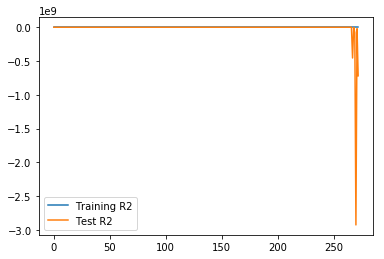

In [26]:
#print(selected_features)
#print(train_accuracy)
#print(test_accuracy)
plt.plot(train_accuracy, label = 'Training R2')
plt.plot(val_accuracy, label = 'Test R2')
plt.legend()
plt.show()

In [51]:
print(r2_score([4, 3, 2, 1], [4, 3, 2, 999]))

-199199.8


In [53]:
bad_features = ['OverallQual', 'log_GrLivArea', 'BsmtFinSF1', 'YearBuilt', 'LotArea', 'OverallCond', 'SaleCondition_Abnorml', 'TotalBsmtSF', 'Neighborhood_Crawfor', 'GarageArea', 'HeatingQC_Ex', 'KitchenAbvGr', 'KitchenQual_Ex', 'Neighborhood_BrDale', 'Functional_Maj2', 'Condition1_Norm', 'BsmtExposure_Gd', 'Street_Grvl', 'MSZoning_FV', 'Neighborhood_StoneBr', 'Neighborhood_NoRidge', 'LotConfig_FR2', 'BsmtFinSF2', '2ndFlrSF', 'log_1stFlrSF', 'BedroomAbvGr', 'Exterior1st_BrkFace', 'Neighborhood_MeadowV', 'Functional_Mod', 'FullBath', 'Functional_Maj1', 'GarageCond_Fa', 'WoodDeckSF', 'Fireplaces', 'HeatingQC_Gd', 'BsmtFinType1_GLQ', 'MasVnrType_BrkFace', 'MSZoning_RL', 'ExterQual_Fa', 'BsmtQual_Gd', 'KitchenQual_Gd', 'EnclosedPorch', 'BsmtCond_Gd', 'ScreenPorch', 'Neighborhood_Edwards', 'BsmtFinType2_GLQ', 'Exterior2nd_BrkFace', 'BsmtFinType1_Rec', 'Functional_Min1', 'ExterCond_TA', 'BsmtFinType2_Rec', 'Heating_Grav', 'BsmtFinType1_LwQ', 'Neighborhood_OldTown', 'MSZoning_RM', 'SaleType_ConLI', 'OpenPorchSF', 'LowQualFinSF', 'Condition2_Feedr', 'Neighborhood_Gilbert', 'MasVnrArea', 'Condition1_PosN', 'LandSlope_Mod', 'Exterior2nd_Wd Sdng', 'Fence_MnPrv', 'RoofStyle_Mansard', 'Heating_GasW', 'BsmtExposure_Mn', 'KitchenQual_Fa', 'Fence_GdWo', 'ExterCond_Gd', 'GarageQual_Gd', 'BsmtFinType2_LwQ', 'GarageType_Attchd', 'GarageType_CarPort', 'KitchenQual_TA', 'GarageType_Basment', 'BsmtCond_NotApplicable', 'Condition1_RRAe', 'Neighborhood_Sawyer', 'Condition2_PosA', 'BsmtFinType2_BLQ', 'FireplaceQu_Po', 'PoolQC_Fa', 'LotShape_IR3', 'HouseStyle_2Story', 'Condition2_Norm', 'GarageQual_Fa', 'LotConfig_FR3', 'Exterior2nd_Stone', 'Neighborhood_NridgHt', 'ExterQual_Ex', 'PavedDrive_N', 'LotShape_Reg', 'GarageFinish_Fin', 'MasVnrType_BrkCmn', 'GarageCond_Ex', 'SaleType_CWD', 'Condition2_PosN', 'Heating_Wall', 'HeatingQC_Po', 'MasVnrType_Stone', 'Fence_GdPrv', 'RoofMatl_WdShake', 'Utilities_AllPub', 'HouseStyle_SLvl', 'BsmtCond_Ex', 'HasGarage', 'GarageQual_TA', 'HalfBath', 'GarageCond_Gd', 'GarageFinish_RFn', 'Exterior1st_Stone', 'BsmtUnfSF', 'BsmtFinType2_NotApplicable', 'GarageCond_NotApplicable', 'PoolQC_TA', 'Neighborhood_GrnHill', 'GarageFinish_NotApplicable', 'Street_Pave', 'BsmtFinType1_NotApplicable', 'GarageFinish_Unf', 'GarageQual_NotApplicable', 'GarageType_Detchd', 'HasBsmt', 'SaleCondition_Alloca', 'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofMatl_Tar&Grv', 'BsmtQual_NotApplicable', 'ExterCond_Fa', 'SaleType_ConLw', 'HouseStyle_1Story', 'MasVnrType_None', 'Foundation_Slab', 'Neighborhood_NAmes', 'Exterior2nd_MetalSd', 'BsmtQual_Fa', '3SsnPorch', 'BsmtExposure_NotApplicable', 'FireplaceQu_Fa', 'Foundation_BrkTil', 'MasVnrType_NotApplicable', 'GarageType_NotApplicable', 'Exterior1st_WdShing', 'Heating_GasA', 'Neighborhood_NPkVill', 'HasPool', 'PoolArea', 'BldgType_2fmCon', 'HouseStyle_1.5Fin', 'Neighborhood_Greens', 'Fence_NotApplicable', 'Neighborhood_Blmngtn', 'GarageQual_Ex', 'LandSlope_Sev', 'LandContour_Lvl', 'Exterior1st_AsbShng', 'HouseStyle_SFoyer', 'BldgType_Duplex', 'BsmtCond_TA', 'LandContour_Bnk', 'Neighborhood_ClearCr', 'Heating_OthW', 'Fence_MnWw', 'BldgType_TwnhsE', 'Exterior1st_Stucco', 'FireplaceQu_Ex', 'HouseStyle_2.5Unf', 'MSZoning_C (all)', 'BsmtFinType1_ALQ', 'SaleType_WD ', 'RoofStyle_Hip', 'BsmtExposure_No', 'FireplaceQu_NotApplicable', 'Functional_Typ', 'GarageType_2Types', 'Exterior1st_BrkComm', 'ExterCond_Po', 'SaleType_ConLD', 'YearRemodAdd', 'SaleCondition_AdjLand', 'Foundation_Stone', 'LotConfig_Inside', 'HouseStyle_1.5Unf', 'Neighborhood_SWISU', 'Exterior2nd_Stucco', 'MSZoning_RH', 'LotFrontage', 'HasLotFrontage', 'Exterior1st_MetalSd', 'BsmtQual_Ex', 'Electrical_FuseA', 'LandContour_Low', 'LandContour_HLS', 'Functional_Min2', 'LandSlope_Gtl', 'Electrical_FuseP', 'GarageQual_Po', 'GarageType_BuiltIn', 'BsmtExposure_Av', 'Alley_Grvl', 'PoolQC_NotApplicable', 'Neighborhood_Mitchel', 'BsmtHalfBath', 'LotConfig_CulDSac', 'Exterior1st_Plywood', 'BsmtCond_Fa', 'BsmtFinType2_Unf', 'Exterior2nd_AsbShng', 'Electrical_SBrkr', 'LotConfig_Corner', 'BsmtFinType2_ALQ', 'Exterior2nd_Brk Cmn', 'LotShape_IR2', 'SaleType_Oth', 'Condition1_RRNe', 'Neighborhood_SawyerW', 'Electrical_FuseF', 'LotShape_IR1', 'HeatingQC_Fa', 'HeatingQC_TA', 'Neighborhood_CollgCr', 'Neighborhood_IDOTRR', 'GarageYrBlt', 'RoofMatl_CompShg', 'Neighborhood_Timber', 'Neighborhood_NWAmes', 'Neighborhood_Veenker', 'Condition1_RRAn', 'Foundation_CBlock', 'Neighborhood_BrkSide', 'MoSold', 'ExterQual_TA', 'SaleCondition_Family', 'Exterior2nd_Plywood', 'BsmtQual_TA', 'ExterQual_Gd', 'RoofStyle_Gable', 'Exterior2nd_CmentBd', 'Exterior2nd_ImStucc', 'Exterior1st_Wd Sdng', 'TotRmsAbvGrd', 'Condition1_Feedr', 'Alley_Pave', 'Alley_NotApplicable', 'Exterior2nd_AsphShn', 'Exterior2nd_HdBoard', 'Exterior1st_VinylSd', 'Exterior1st_CemntBd', 'Exterior1st_HdBoard', 'Exterior2nd_VinylSd', 'Condition1_PosA', 'SaleCondition_Normal', 'Condition1_Artery', 'Exterior2nd_Wd Shng', 'GarageCars', 'SaleCondition_Partial', 'SaleType_COD', 'BldgType_1Fam', 'YrSold', 'Neighborhood_Somerst', 'SaleType_New', 'FireplaceQu_TA', 'MSSubClass']
lr = linear_model.LinearRegression()
lr.fit(X_train[really_bad_feature_set], y_train)

y_pred = lr.predict(X_test[really_bad_feature_set])
r2_score(y_test, y_pred)

-441675916.37317991

In [60]:
better_feature_set = ['OverallQual', 'log_GrLivArea', 'BsmtFinSF1', 'YearBuilt', 'LotArea', 'OverallCond', 'SaleCondition_Abnorml', 'TotalBsmtSF', 'Neighborhood_Crawfor', 'GarageArea', 'HeatingQC_Ex', 'KitchenAbvGr', 'KitchenQual_Ex', 'Neighborhood_BrDale', 'Functional_Maj2', 'Condition1_Norm', 'BsmtExposure_Gd', 'Street_Grvl', 'MSZoning_FV', 'Neighborhood_StoneBr', 'Neighborhood_NoRidge', 'LotConfig_FR2', 'BsmtFinSF2', '2ndFlrSF', 'log_1stFlrSF', 'BedroomAbvGr', 'Exterior1st_BrkFace', 'Neighborhood_MeadowV', 'Functional_Mod', 'FullBath', 'Functional_Maj1', 'GarageCond_Fa', 'WoodDeckSF', 'Fireplaces', 'HeatingQC_Gd', 'BsmtFinType1_GLQ', 'MasVnrType_BrkFace', 'MSZoning_RL', 'ExterQual_Fa', 'BsmtQual_Gd', 'KitchenQual_Gd', 'EnclosedPorch', 'BsmtCond_Gd', 'ScreenPorch', 'Neighborhood_Edwards', 'BsmtFinType2_GLQ', 'Exterior2nd_BrkFace', 'BsmtFinType1_Rec', 'Functional_Min1', 'ExterCond_TA', 'BsmtFinType2_Rec', 'Heating_Grav', 'BsmtFinType1_LwQ', 'Neighborhood_OldTown', 'MSZoning_RM', 'SaleType_ConLI', 'OpenPorchSF', 'LowQualFinSF', 'Condition2_Feedr', 'Neighborhood_Gilbert', 'MasVnrArea', 'Condition1_PosN', 'LandSlope_Mod', 'Exterior2nd_Wd Sdng', 'Fence_MnPrv', 'RoofStyle_Mansard', 'Heating_GasW', 'BsmtExposure_Mn', 'KitchenQual_Fa', 'Fence_GdWo', 'ExterCond_Gd', 'GarageQual_Gd', 'BsmtFinType2_LwQ', 'GarageType_Attchd', 'GarageType_CarPort', 'KitchenQual_TA', 'GarageType_Basment', 'BsmtCond_NotApplicable', 'Condition1_RRAe', 'Neighborhood_Sawyer', 'Condition2_PosA', 'BsmtFinType2_BLQ', 'FireplaceQu_Po', 'PoolQC_Fa', 'LotShape_IR3', 'HouseStyle_2Story', 'Condition2_Norm', 'GarageQual_Fa', 'LotConfig_FR3', 'Exterior2nd_Stone', 'Neighborhood_NridgHt', 'ExterQual_Ex', 'PavedDrive_N', 'LotShape_Reg']
lr = linear_model.LinearRegression()
lr.fit(X_train[better_feature_set], y_train)

y_pred = lr.predict(X_test[better_feature_set])
r2_score(y_test, y_pred)

0.93410599927345506

## Try again with ALL features

In [123]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
print('On train: {0}:'.format(r2_score(y_train, y_pred)))

y_pred = lr.predict(X_test)
print('On test: {0}:'.format(r2_score(y_test, y_pred)))

write_to_csv(np.exp(y_test), np.exp(y_pred), 'Linear.csv')

On train: 0.9474044833165055:
On test: 0.93825121660914:


In [124]:
lr_geo = linear_model.LinearRegression()
lr_geo.fit(X_geo_train, y_geo_train)

y_pred_train = lr_geo.predict(X_geo_train)
print('On train: {0}'.format(r2_score(y_geo_train, y_pred_train)))

y_pred = lr_geo.predict(X_geo_test)
print('On test: {0}'.format(r2_score(y_geo_test, y_pred)))

write_to_csv(np.exp(y_geo_test), np.exp(y_pred), 'Linear_with_geo.csv')

On train: 0.950753581393851
On test: 0.927283123070852


On train: 0.9461437277873921:
On test: 0.9384955982344393:


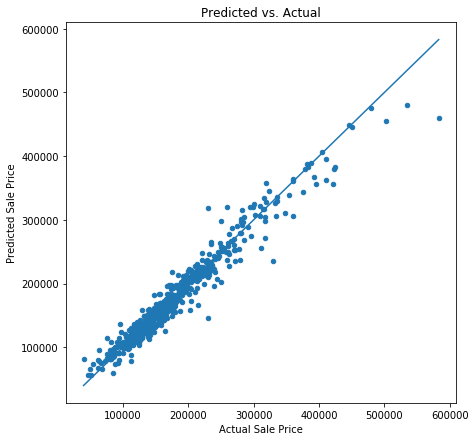

Final r2 score: 0.9495966899007803
Median margin of error: 0.04760241389851841
RMSE is: 17177.317510022633


In [125]:
rid = linear_model.Ridge()
rid.fit(X_train, y_train)

y_pred = rid.predict(X_train)
print('On train: {0}:'.format(r2_score(y_train, y_pred)))

y_pred = rid.predict(X_test)
print('On test: {0}:'.format(r2_score(y_test, y_pred)))

y_test_norm = np.exp(y_test)
y_pred_norm = np.exp(y_pred)
summary.pred_vs_actual_plot(y_pred_norm, y_test_norm)
print('Final r2 score: {0}'.format(r2_score(y_test_norm, y_pred_norm)))
median_margin_of_error = np.median(np.abs((y_pred_norm - y_test_norm) / y_test_norm))
print('Median margin of error: {0}'.format(median_margin_of_error))
rmse = sqrt(mean_squared_error(y_test_norm, y_pred_norm))
print('RMSE is: {0}'.format(rmse))

write_to_csv(np.exp(y_test), np.exp(y_pred), 'Ridge.csv')

On train: 0.9475598593010872
On test: 0.9397249388837053


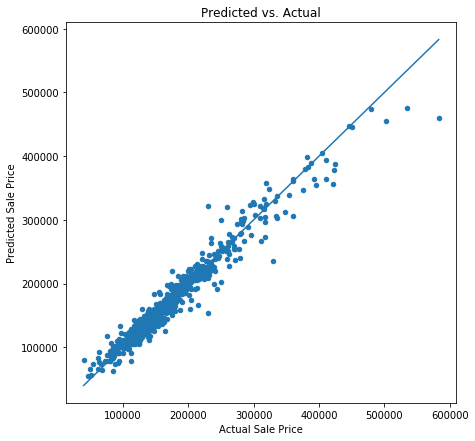

Final r2 score: 0.9497041969684099
Median margin of error: 0.04558322777476602
RMSE is: 17158.988666166337


In [126]:
rid_geo = linear_model.Ridge()
rid_geo.fit(X_geo_train, y_geo_train)

y_geo_pred_train = rid_geo.predict(X_geo_train)
print('On train: {0}'.format(r2_score(y_geo_train, y_geo_pred_train)))

y_geo_pred_test = rid_geo.predict(X_geo_test)
print('On test: {0}'.format(r2_score(y_geo_test, y_geo_pred_test)))

y_geo_test_norm = np.exp(y_geo_test)
y_geo_pred_norm = np.exp(y_geo_pred)
summary.pred_vs_actual_plot(y_geo_pred_norm, y_geo_test_norm)
print('Final r2 score: {0}'.format(r2_score(y_geo_test_norm, y_geo_pred_norm)))
median_margin_of_error = np.median(np.abs((y_geo_pred_norm - y_geo_test_norm) / y_geo_test_norm))
print('Median margin of error: {0}'.format(median_margin_of_error))
rmse = sqrt(mean_squared_error(y_geo_test_norm, y_geo_pred_norm))
print('RMSE is: {0}'.format(rmse))

write_to_csv(np.exp(y_geo_test), np.exp(y_geo_pred_test), 'Ridge_with_geo.csv')

In [122]:
lasso = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005],max_iter=100000)
lasso.fit(X_train, y_train)
y_pred_train = lasso.predict(X_train)
print('On train: {0}'.format(r2_score(y_train, y_pred_train)))
      
y_pred_test = lasso.predict(X_test)
print('On test: {0}'.format(r2_score(np.exp(y_test), np.exp(y_pred_test)))) 

write_to_csv(np.exp(y_test), np.exp(y_pred_test), 'Lasso.csv')

On train: 0.9381698055770009
On test: 0.9481048674701982


In [120]:
lasso = linear_model.LassoCV(alphas = [1, 0.1, 0.001, 0.0005],max_iter=100000)
lasso.fit(X_geo_train, y_geo_train)
y_pred_train = lasso.predict(X_geo_train)
print('On train: {0}'.format(r2_score(y_geo_train, y_pred_train)))
      
y_pred_test = lasso.predict(X_geo_test)
print('On test: {0}'.format(r2_score(np.exp(y_geo_test), np.exp(y_pred_test)))) 

write_to_csv(np.exp(y_geo_test), np.exp(y_pred_test), 'Lasso_with_geo.csv')

On train: 0.9387880578605082
On test: 0.9488570378358722
saving as ../data/output/Lasso_with_geo.csv


In [121]:
def write_to_csv(actual, prediction, name):
    with open('../data/output/'+name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ',
                                quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['actual,prediction'])
        for act, pred in zip(actual, prediction):
            writer.writerow([act] + [','] + [pred])